In [1]:
 import torch

In [2]:
# !pip install wget

In [3]:
# import wget

# url = 'https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/MRIs.zip'
# wget.download(url)

In [4]:
# import zipfile
# with zipfile.ZipFile('MRIs.zip', 'r') as zip_ref:
#     zip_ref.extractall('.')


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
from pathlib import Path

path = Path('/content/drive/MyDrive/DatasetSegmentacion')
img_dir = path / 'bolsa'
mask_dir = path / 'segmentaciones'

imgs = [img_dir / i for i in os.listdir(img_dir)]
masks = []

for img_path in imgs:
    img_name = img_path.stem  # Obtener el nombre del archivo sin la extensión
    mask_name = img_name + '_mask.png'  # Construir el nombre del archivo de la máscara
    mask_path = mask_dir / mask_name  # Ruta completa de la máscara
    masks.append(mask_path)

print(len(imgs), len(masks))

1008 1008


In [7]:
print(imgs[1])
print(masks[1])

/content/drive/MyDrive/DatasetSegmentacion/bolsa/0022_jpg.rf.ea9dc7374b10f18b4d66ce34fcc36ab2.jpg
/content/drive/MyDrive/DatasetSegmentacion/segmentaciones/0022_jpg.rf.ea9dc7374b10f18b4d66ce34fcc36ab2_mask.png


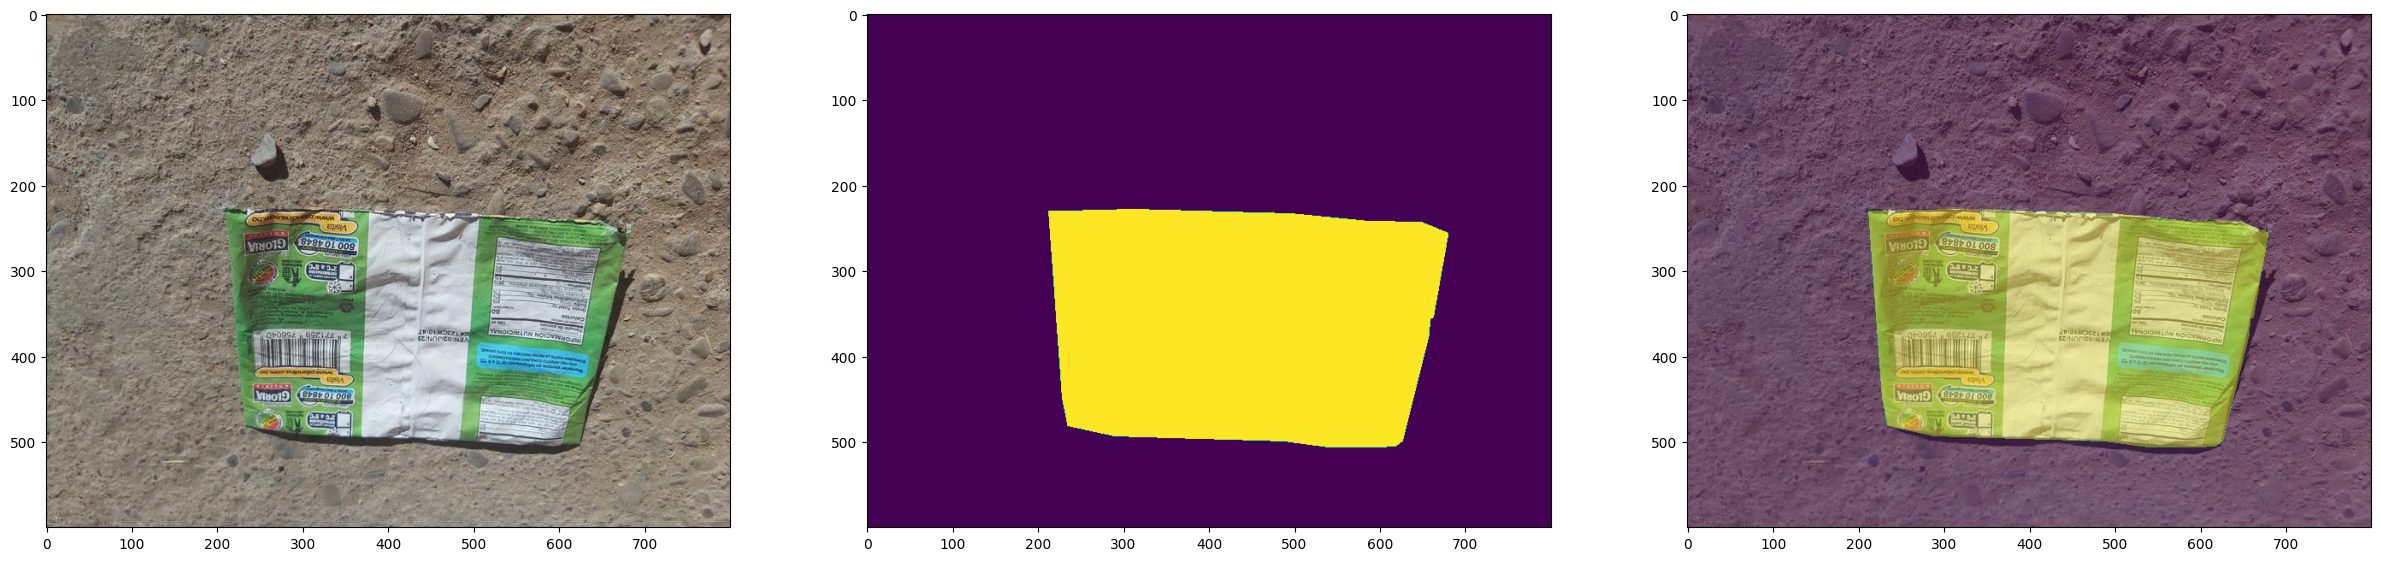

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
imagen = Image.open(imgs[0])
mascara = Image.open(masks[0])
img = np.array(imagen)
mask = np.array(mascara)
# img = np.load(imgs[0])
# mask = np.load(masks[0])
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(img)
ax3.imshow(mask, alpha=0.4)
plt.show()

Nuestras imágenes tienen 394 x 394 píxeles, almacenadas como `arrays` de `NumPy` (que podemos cargar con la función `np.load`). Ya están normalizadas y en formato `float32`.

In [9]:
img.shape, img.dtype, img.max(), img.min()

((600, 800, 3), dtype('uint8'), 255, 0)

En cuanto a las máscaras, también las tenemos guardadas como `arrays` de `NumPy`. En este caso el tipo es `unit8`, y la resolución es la misma que las de la imagen original. En cada píxel podemos encontrar tres posibles valores: 0, 1 ó 2. Este valor indica la clase (0 corresponde con materia blanca, 1 con materia gris, 2 con *background*).

In [10]:
mask.shape, mask.dtype, mask.max(), mask.min()

((600, 800), dtype('uint8'), 1, 0)

A la hora de entrenar nuestra red necesitaremos esta máscara en formato `one-hot encoding`, en el que extenderemos cada pixel en una lista de longitud igual al número de clases (en este caso 3) con valores de 0 en todas las posiciones excepto en aquella que corresponda con la clase, dónde pondremos un 1.

In [11]:
# one-hot encoding
mask_oh = (np.arange(3) == mask[...,None]).astype(np.float32) 

mask_oh.shape, mask_oh.dtype, mask_oh.max(), mask_oh.min()

((600, 800, 3), dtype('float32'), 1.0, 0.0)

In [12]:
from skimage import io

In [13]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, n_classes=3):
    self.X = X
    self.y = y
    self.n_classes = n_classes

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # img = np.array(Image.open(self.X[ix]))
    # mask = np.array(Image.open(self.y[ix]))
    img = Image.open(self.X[ix])
    mask = Image.open(self.y[ix])

    # Redimensionar imágenes
    img = img.resize((224,224))
    mask = mask.resize((224,224))

    img = np.array(img)
    mask = np.array(mask)
    img = torch.from_numpy(img / 255.).float().permute(2,0,1).unsqueeze(0) 
    mask = (np.arange(self.n_classes) == mask[...,None]).astype(np.float32) 
    return img.squeeze(), torch.from_numpy(mask).permute(2,0,1)

In [14]:
dataset = {
    'train': Dataset(imgs[:-100], masks[:-100]),
    'test': Dataset(imgs[-100:], masks[-100:])
}

len(dataset['train']), len(dataset['test'])

(908, 100)

In [15]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=5, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=8, pin_memory=True)
}

imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([5, 3, 224, 224]), torch.Size([5, 3, 224, 224]))

In [16]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
      bar = tqdm(dataloader['train'])
      train_loss, train_iou = [], []
      model.train()
      for imgs, masks in bar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = criterion(y_hat, masks)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, masks)
        train_loss.append(loss.item())
        train_iou.append(ious)
        bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
      hist['loss'].append(np.mean(train_loss))
      hist['iou'].append(np.mean(train_iou))
      bar = tqdm(dataloader['test'])
      test_loss, test_iou = [], []
      model.eval()
      with torch.no_grad():
        for imgs, masks in bar:
          imgs, masks = imgs.to(device), masks.to(device)
          y_hat = model(imgs)
          loss = criterion(y_hat, masks)
          ious = iou(y_hat, masks)
          test_loss.append(loss.item())
          test_iou.append(ious)
          bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
      hist['test_loss'].append(np.mean(test_loss))
      hist['test_iou'].append(np.mean(test_iou))
      print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
    return hist

In [17]:
import torchvision
import torch

In [18]:
# encoder = torchvision.models.resnet18(pretrained=True)
# encoder
# encoder = torchvision.models.googlenet(pretrained=True)
# encoder

encoder = torchvision.models.inception_v3(pretrained=True)
encoder

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 61.0MB/s] 


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [19]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))  
        union = (_out | _labs).float().sum((1, 2))         
        iou = (intersection + SMOOTH) / (union + SMOOTH)  
        ious.append(iou.mean().item())
    return np.mean(ious) 

In [20]:
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, kernel_size=4, stride=2, padding=1)
        self.conv1 = conv3x3_bn(ci + co, co)
        self.conv2 = conv3x3_bn(co, co)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (0, diffY, 0, diffX))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [36]:
class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=1):
        super().__init__()

        self.encoder = torchvision.models.inception_v3(pretrained=True)
        if in_ch != 3:
            self.encoder.Conv2d_1a_3x3.conv = torch.nn.Conv2d(
                in_ch, 32, kernel_size=3, stride=2, bias=False
            )

        self.deconv1 = deconv(2048,768)
        self.deconv2 = deconv(768,288)
        self.deconv3 = deconv(288,192)
        self.out = out_conv(192, 192, n_classes)

    def forward(self, x):
        x_in = torch.tensor(x.clone())
        # x = self.encoder.Conv2d_2b_3x3(self.encoder.Conv2d_3a_3x3(self.encoder.Conv2d_4a_3x3(x)))
        x = self.encoder.maxpool2(self.encoder.Conv2d_4a_3x3(self.encoder.Conv2d_3b_1x1(self.encoder.maxpool1(self.encoder.Conv2d_2b_3x3(self.encoder.Conv2d_2a_3x3(self.encoder.Conv2d_1a_3x3(x)))))))
        # x = self.encoder.Conv2D_1a_3x3(x)
        # print("X: ",x.shape)
        x1 = self.encoder.Mixed_5d(self.encoder.Mixed_5c(self.encoder.Mixed_5b(x)))
        # print("X1: ",x1.shape)
        x2 = self.encoder.Mixed_6e(self.encoder.Mixed_6d(self.encoder.Mixed_6c(self.encoder.Mixed_6b(self.encoder.Mixed_6a(x1)))))
        # print("X2: ",x2.shape)
        x3 = self.encoder.Mixed_7c(self.encoder.Mixed_7b(self.encoder.Mixed_7a(x2)))
        # print("X3: ",x3.shape)
        x = self.encoder.avgpool(x3)
        # print("X: ",x.shape)
        x = self.deconv1(x, x3)
        # print("X Deconv: ",x.shape)
        x = self.deconv2(x, x2)
        # print("X Deconv: ",x.shape)
        x = self.deconv3(x, x1)
        # print("X Deconv: ",x.shape)
        x = self.out(x, x_in)
        # print("X Deconv: ",x.shape)
        return x

In [37]:
model = UNetResnet(in_ch=3)
output = model(torch.randn((5,3,224,224)))
output.shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-36-4bbd1f2710dd>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


torch.Size([5, 3, 224, 224])

In [38]:
hist = fit(model, dataloader, epochs=30)

  0%|          | 0/182 [00:00<?, ?it/s]<ipython-input-36-4bbd1f2710dd>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())
loss 0.67954 iou 0.11693:   2%|▏         | 4/182 [00:53<39:24, 13.29s/it]


KeyboardInterrupt: ignored

In [ ]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

In [ ]:
import random

model.eval()
with torch.no_grad():
    ix = random.randint(0, len(dataset['test'])-1)
    img, mask = dataset['test'][ix]
    output = model(img.unsqueeze(0).to(device))[0]
    pred_mask = torch.argmax(output, axis=0)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img.permute(1,2,0))
ax2.imshow(torch.argmax(mask, axis=0))
print(pred_mask)
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()